In [1]:
#install pre requisites if not already installed in order to run this notebook
!pip install pyodbc
!pip install pandas
!pip install numpy



In [3]:
#import libraries to perfom reading and cleaning operations in this notebook
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [18]:
#Creating a sql connection [azure sql database], {need to define client ip in azure to access}
conn = pyodbc.connect(
        'DRIVER={SQL Server};SERVER=yashsql.database.windows.net;DATABASE=CC_FUEL;UID=yash;PWD={HIDDDDEEENNNNNN};Trusted_connection=no')
cursor = conn.cursor()
print("Connected")

Connected


## Question 1


In [5]:
#reading the csv file
df = pd.read_csv('fastfood.csv')
print(df)

    restaurant                                       item  calories  cal_fat  \
0    Mcdonalds           Artisan Grilled Chicken Sandwich       380       60   
1    Mcdonalds             Single Bacon Smokehouse Burger       840      410   
2    Mcdonalds             Double Bacon Smokehouse Burger      1130      600   
3    Mcdonalds  Grilled Bacon Smokehouse Chicken Sandwich       750      280   
4    Mcdonalds   Crispy Bacon Smokehouse Chicken Sandwich       920      410   
..         ...                                        ...       ...      ...   
510  Taco Bell             Spicy Triple Double Crunchwrap       780      340   
511  Taco Bell                Express Taco Salad w/ Chips       580      260   
512  Taco Bell                     Fiesta Taco Salad-Beef       780      380   
513  Taco Bell                  Fiesta Taco Salad-Chicken       720      320   
514  Taco Bell                    Fiesta Taco Salad-Steak       720      320   

     total_fat  sat_fat  trans_fat  cho

In [6]:
#replacing and filling NaN values
df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)

In [7]:
df = df.fillna(0)

In [8]:
print(df)

    restaurant                                       item  calories  cal_fat  \
0    Mcdonalds           Artisan Grilled Chicken Sandwich       380       60   
1    Mcdonalds             Single Bacon Smokehouse Burger       840      410   
2    Mcdonalds             Double Bacon Smokehouse Burger      1130      600   
3    Mcdonalds  Grilled Bacon Smokehouse Chicken Sandwich       750      280   
4    Mcdonalds   Crispy Bacon Smokehouse Chicken Sandwich       920      410   
..         ...                                        ...       ...      ...   
510  Taco Bell             Spicy Triple Double Crunchwrap       780      340   
511  Taco Bell                Express Taco Salad w/ Chips       580      260   
512  Taco Bell                     Fiesta Taco Salad-Beef       780      380   
513  Taco Bell                  Fiesta Taco Salad-Chicken       720      320   
514  Taco Bell                    Fiesta Taco Salad-Steak       720      320   

     total_fat  sat_fat  trans_fat  cho

In [12]:

# Creating a table in azure sql database #table-name = fast_food
sql_create_table = "CREATE TABLE fast_food (restaurant VARCHAR(100),item VARCHAR(100),calories INT,cal_fat  INT,total_fat  INT,sat_fat FLOAT,trans_fat FLOAT,cholesterol  INT,sodium  INT,total_carb  INT,fiber  FLOAT,sugar  INT,protein  FLOAT,vit_a  FLOAT,vit_c FLOAT,calcium FLOAT,salad  VARCHAR(100))"

cursor = conn.cursor()
cursor.execute(sql_create_table)
conn.commit()



In [13]:
#Do not run this as this will duplicate the data in the table unless dropping table and recreating it

# Inserting the data into the table -fast_food from the csv
columns = ', '.join(df.columns)
values = ', '.join(['?' for i in range(len(df.columns))])
sql_insert = f"INSERT INTO fast_food ({columns}) VALUES ({values})"

cursor = conn.cursor()
for row in df.itertuples(index=False):
    cursor.execute(sql_insert, row)
cursor.commit()


print("Data inserted successfully!")

Data inserted successfully!


## Question 2

In [14]:
#Reading the data from the azure sql database
sql_select = "SELECT * FROM fast_food"

# Loading the data into pandas dataframe
sql_df = pd.read_sql(sql_select, conn)


print(sql_df)




    restaurant                                       item  calories  cal_fat  \
0    Mcdonalds           Artisan Grilled Chicken Sandwich       380       60   
1    Mcdonalds             Single Bacon Smokehouse Burger       840      410   
2    Mcdonalds             Double Bacon Smokehouse Burger      1130      600   
3    Mcdonalds  Grilled Bacon Smokehouse Chicken Sandwich       750      280   
4    Mcdonalds   Crispy Bacon Smokehouse Chicken Sandwich       920      410   
..         ...                                        ...       ...      ...   
510  Taco Bell             Spicy Triple Double Crunchwrap       780      340   
511  Taco Bell                Express Taco Salad w/ Chips       580      260   
512  Taco Bell                     Fiesta Taco Salad-Beef       780      380   
513  Taco Bell                  Fiesta Taco Salad-Chicken       720      320   
514  Taco Bell                    Fiesta Taco Salad-Steak       720      320   

     total_fat  sat_fat  trans_fat  cho

C:\Users\yashs\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## Question 3

In [19]:
#Calculating the average , minumum  and maximun calories for each restaurant and ordering them by restaurants having least carbs on average
sql_question1 = "SELECT restaurant, AVG(calories) AS avg_calories, MIN(calories) AS min_calories, MAX(calories) AS max_calories, AVG(total_carb) AS avg_carbs FROM fast_food GROUP BY restaurant ORDER BY avg_carbs ASC;"
sql_df1 = pd.read_sql(sql_question1, conn)


print(sql_df1)




    restaurant  avg_calories  min_calories  max_calories  avg_carbs
0  Chick Fil-A           384            70           970         28
1  Dairy Queen           520            20          1260         38
2  Burger King           608           190          1550         39
3        Arbys           532            70          1030         44
4    Taco Bell           443           140           880         46
5        Sonic           631           100          1350         47
6    Mcdonalds           640           140          2430         48
7       Subway           503            50          1160         54


## Question 4

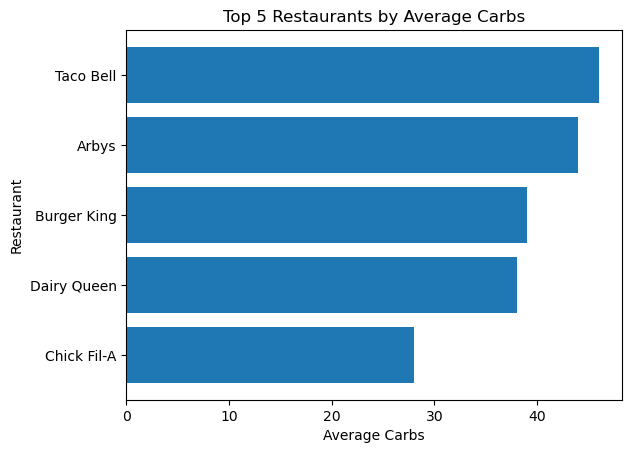

In [20]:
#Using matplot librabry to visualize 
top5 = sql_df1.head(5)
plt.barh(top5['restaurant'], top5['avg_carbs'])
plt.title('Top 5 Restaurants by Average Carbs')
plt.xlabel('Average Carbs')
plt.ylabel('Restaurant')
plt.show()

## Question 5

In [21]:
#Defining a function that categorize the value in column item into 1.Main 2.Side & 3.Dessert depending on protein , total_carb & sugar value
def categorize_food(row):
    if "main" in row["item"].lower()  or row["protein"] > 20:
        return "Main"
    elif "side" in row["item"].lower() or row["total_carb"] > 20:
        return "Side"
    elif "dessert" in row["item"].lower() or row["sugar"] > 20:
        return "Dessert"
    else:
        return "Unknown"

In [22]:
#applying the function to the dataframe 
sql_df["category"] = sql_df.apply(categorize_food,axis=1)

# Printing the resulting dataframe with the added 'category' column
print(sql_df.head(200))

      restaurant                                       item  calories  \
0      Mcdonalds           Artisan Grilled Chicken Sandwich       380   
1      Mcdonalds             Single Bacon Smokehouse Burger       840   
2      Mcdonalds             Double Bacon Smokehouse Burger      1130   
3      Mcdonalds  Grilled Bacon Smokehouse Chicken Sandwich       750   
4      Mcdonalds   Crispy Bacon Smokehouse Chicken Sandwich       920   
..           ...                                        ...       ...   
195  Burger King                  Bacon Cheeseburger Deluxe       290   
196  Burger King                                 Bacon King      1040   
197  Burger King                              Bacon King Jr       730   
198  Burger King                             BBQ Bacon King      1100   
199  Burger King                               Cheeseburger       300   

     cal_fat  total_fat  sat_fat  trans_fat  cholesterol  sodium  total_carb  \
0         60          7      2.0        0.0

## Question 6

In [24]:
#adding  sub categories into the "Main" Category 
def sub_categorize_food(row):
    if "main" in row["item"].lower()  or row["protein"] > 20:
        
        protein_source = []
        if "chicken" in row["item"].lower() or "poultry" in row["item"].lower() or "turkey" in row["item"].lower():
            protein_source.append("Chicken")
        if "beef" in row["item"].lower() or "steak" in row["item"].lower() :
            protein_source.append("Beef")
        if "seafood" in row["item"].lower() or "fish" in row["item"].lower() or "shrimp" in row["item"].lower():
            protein_source.append("Seafood")
        if "pork" in row["item"].lower() or "bacon" in row["item"].lower() or "ham" in row["item"].lower():
            protein_source.append("Pork")
        if not protein_source:
            protein_source.append("Other")
        return f"Main ({', '.join(protein_source)})"
    elif "side" in row["item"].lower() or row["total_carb"] > 20:
        return "Side"
    elif "dessert" in row["item"].lower() or row["sugar"] > 20:
        return "Dessert"
    else:
        return "Unknown"

In [25]:
#applying the function to the dataframe
sql_df["category"] = sql_df.apply(sub_categorize_food,axis=1)


print(sql_df.head(200))

      restaurant                                       item  calories  \
0      Mcdonalds           Artisan Grilled Chicken Sandwich       380   
1      Mcdonalds             Single Bacon Smokehouse Burger       840   
2      Mcdonalds             Double Bacon Smokehouse Burger      1130   
3      Mcdonalds  Grilled Bacon Smokehouse Chicken Sandwich       750   
4      Mcdonalds   Crispy Bacon Smokehouse Chicken Sandwich       920   
..           ...                                        ...       ...   
195  Burger King                  Bacon Cheeseburger Deluxe       290   
196  Burger King                                 Bacon King      1040   
197  Burger King                              Bacon King Jr       730   
198  Burger King                             BBQ Bacon King      1100   
199  Burger King                               Cheeseburger       300   

     cal_fat  total_fat  sat_fat  trans_fat  cholesterol  sodium  total_carb  \
0         60          7      2.0        0.0

## Question 7

In [27]:
#Saving the pandas dataframe as csv
sql_df.to_csv('food_cats.csv', index=False)

## End of NoteBook